In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, 
                                     Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
import os  # Provides functions for interacting with the operating system
import cv2  # OpenCV library for image and video processing
import torch  # PyTorch library for deep learning
import imghdr  # Used to determine the type of image contained in a file
import torchvision  # PyTorch library for vision-related tasks
import numpy as np  # Fundamental package for scientific computing with Python
import pandas as pd  # Data manipulation and analysis library
import tensorflow as tf  # TensorFlow library for deep learning
import matplotlib.pyplot as plt  # Plotting library for creating static, animated, and interactive visualizations
from sklearn.utils import shuffle # For shuffling dataset
from tensorflow.keras import layers  # Core Keras layers API
from tensorflow.keras.models import Sequential  # Sequential model API in Keras
from tensorflow.keras.optimizers import RMSprop  # RMSprop optimizer
from tensorflow.keras.applications import VGG16 # Import pre-trained VGG16 model for feature extraction
from tensorflow.keras.applications.vgg16 import preprocess_input # Function to preprocess input images for VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation and preprocessing for image data
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy  # Metrics for model evaluation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout  # Core layers for building CNN models

In [3]:
#Importing our datasets
data_dir = '/kaggle/input/downsyndrome/downSyndrome - Copy'

In [4]:
#Building Data pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 13512 files belonging to 2 classes.


In [5]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
len(data)

423

In [8]:
#resizing shape to none,224,224,3
import tensorflow as tf

# Assuming `dataset` is your original dataset with images of shape (256, 256, 3)
target_height, target_width = 224, 224

def resize_images(image, label):
    # Resize the image to the desired shape
    image = tf.image.resize(image, [target_height, target_width])
    return image, label

# Apply the resizing transformation to the dataset
data = data.map(resize_images)

In [9]:
data

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
len(data)

423

In [11]:
# Converting the dataset to an iterator
data_iterator = data.as_numpy_iterator()

# Acessing a batch from the Datapipeline
batch = data_iterator.next()
len(batch)

2

In [12]:
# Displaying the shape of the batch
batch[0].shape

(32, 224, 224, 3)

In [13]:
# Displaying the class labels
#Class 1 = Normal
#Class 0 = Down
batch[1]

array([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

In [14]:
# Display the shape of the image batch
print(batch[0].shape)  # Should be (batch_size, height, width, channels)

# Display the labels
print(batch[1])  # Array of labels corresponding to the batch

(32, 224, 224, 3)
[0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1]


In [15]:
# Converting the features array into a DataFrame
df_features = pd.DataFrame(batch[1])
print(df_features)

    0
0   0
1   1
2   0
3   1
4   1
5   1
6   1
7   0
8   1
9   1
10  0
11  0
12  0
13  1
14  0
15  0
16  1
17  1
18  0
19  1
20  0
21  0
22  0
23  0
24  0
25  1
26  1
27  1
28  0
29  1
30  1
31  1


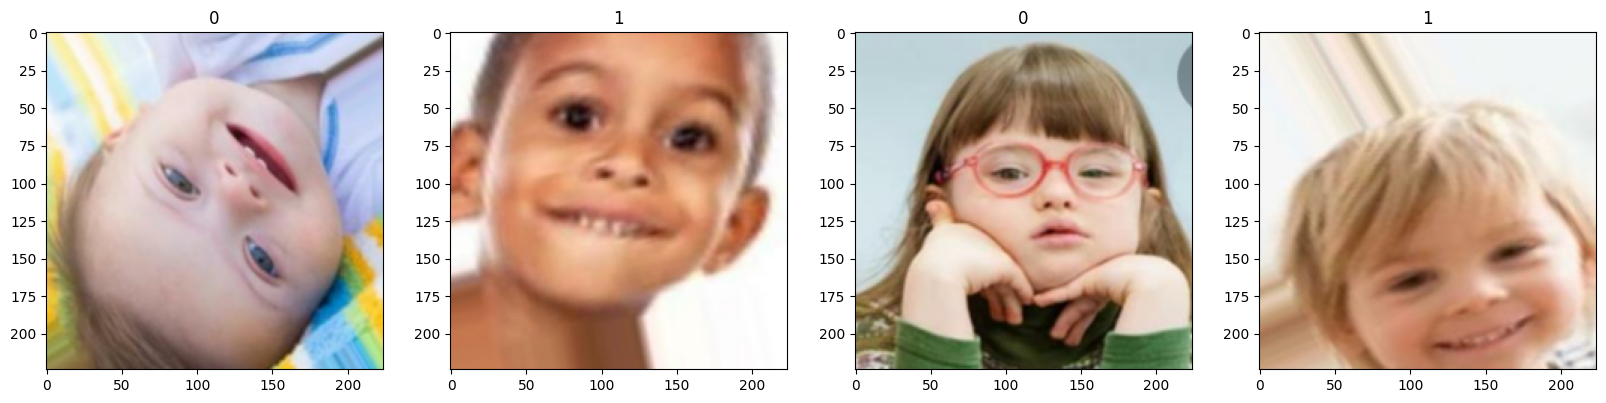

In [16]:
#Data visualization
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

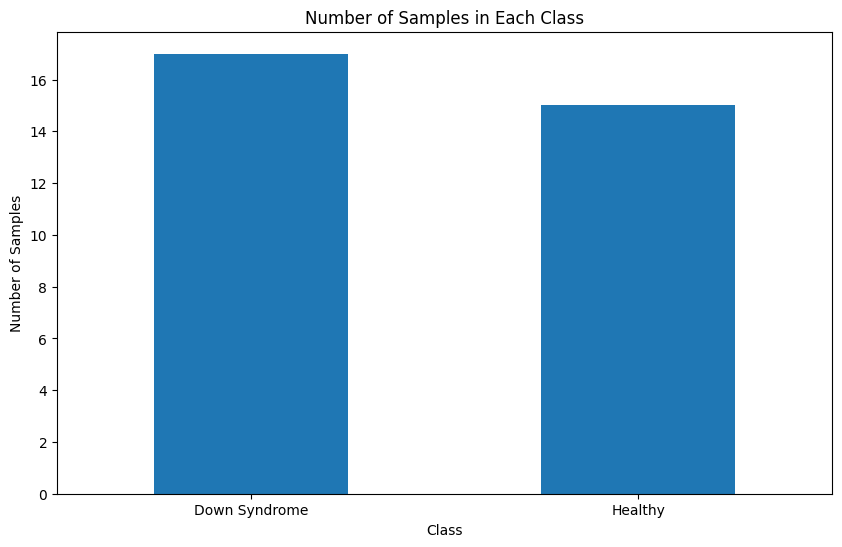

In [17]:
# Converting the features array into a DataFrame
df_features = pd.DataFrame(batch[1], columns=['Class'])

# Counting the number of samples in each class
class_counts = df_features['Class'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Number of Samples in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1], labels=['Down Syndrome', 'Healthy'], rotation=0)
plt.show()

In [18]:
class_counts

Class
1    17
0    15
Name: count, dtype: int64

In [19]:
#Data Preprocessing

#Data scaling
data = data.map(lambda x, y: (x / 255.0, y))  # Scale images to [0, 1]

# Verifying scaling
print(data.as_numpy_iterator().next()[0].min())  # Should print 0.0

0.0


In [20]:
#Checking lenght of dataset
len(data)

423

In [21]:
#Data splitting
train_size = int(len(data)*.7)
val_size = int(len(data)*.15)
test_size = int(len(data)*.15)

In [22]:
#checking our data size
train_size,val_size, test_size

(296, 63, 63)

In [23]:
#Assigning suitable variable names
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [24]:
#Creating Model¶
#I tried Different model architecture like VGG, mobilenet but DenseNet works best

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

def get_model():
    densenet = DenseNet121(weights='imagenet',
                           include_top=False,
                           input_shape=(224, 224, 3)
                          )
    model = tf.keras.models.Sequential([
        densenet,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                 )
    return model

spoofnet = get_model()
spoofnet.build(input_shape=(None, 224, 224, 3))  # Specify batch size as None for flexibility
spoofnet.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,564,865 (28.86 MB)

 Trainable params: 7,480,193 (28.53 MB)

 Non-trainable params: 84,672 (330.75 KB)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

checkpoint = ModelCheckpoint(filepath='spoffnet.keras',  # changed '.h5' to '.keras'
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='loss'  # changed 'val_loss' to 'loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='loss',  # changed 'val_loss' to 'loss'
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('train.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [27]:
# Fit the model with appropriate steps
hist = spoofnet.fit(
    train,
    validation_data=val,
    callbacks=callbacks,
    epochs=5
)

Epoch 1/5


I0000 00:00:1731596237.396188     103 service.cc:145] XLA service 0x7fb9a8003ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731596237.396253     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731596331.696434     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7531 - loss: 0.5760
Epoch 1: loss improved from inf to 0.43121, saving model to spoffnet.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 231s 261ms/step - accuracy: 0.7533 - loss: 0.5756 - val_accuracy: 0.8517 - val_loss: 0.3340 - learning_rate: 0.0010
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8934 - loss: 0.2522
Epoch 2: loss improved from 0.43121 to 0.23563, saving model to spoffnet.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 69s 233ms/step - accuracy: 0.8934 - loss: 0.2522 - val_accuracy: 0.8963 - val_loss: 0.2396 - learning_rate: 0.0010
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9213 - loss: 0.1998
Epoch 3: loss improved from 0.23563 to 0.18391, saving model to spoffnet.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 68s 230ms/step - accuracy: 0.9213 - loss: 0.1997 - val_accuracy: 0.8571 - val_loss: 0.3370 - learning_rate: 0.0010
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9429 - loss: 0.1

In [29]:
_, accu = spoofnet.evaluate(test)
print('Final Test Accuracy = {:.3f}%'.format(accu * 100))

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.9255 - loss: 0.2002
Final Test Accuracy = 92.659%


In [31]:
teacher=spoofnet

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted class: 841 with probability 0.10


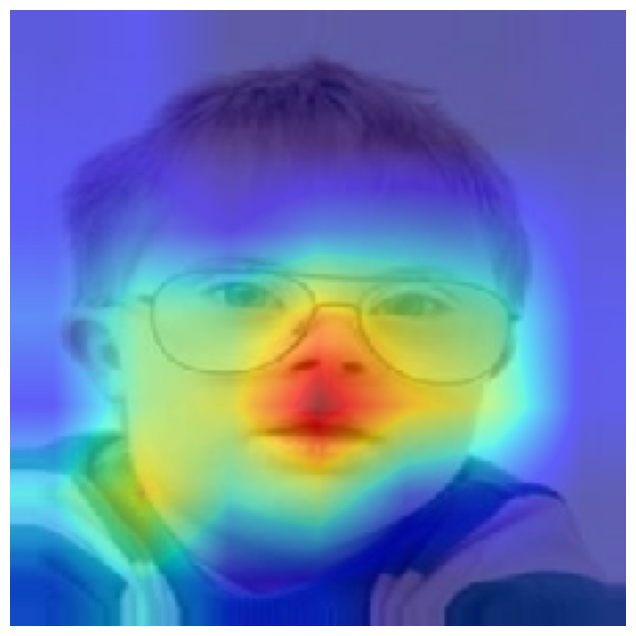

In [2]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image

# Load pre-trained DenseNet121 model
model = DenseNet121(weights='imagenet')

# Prepare your image
IMG_NAME = '/kaggle/input/test-sample/filtered aug dataset/DS/downsyndrome/DS__1071.jpg'  # Path to your image
img = image.load_img(IMG_NAME, target_size=(224, 224))  # Resize image to (224, 224)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)  # Add batch dimension
x = tf.keras.applications.densenet.preprocess_input(x)

# Step 1: Get the last convolutional layer (conv5_block16_2_conv for DenseNet121)
last_conv_layer = model.get_layer('conv5_block16_2_conv')

# Step 2: Create a new model to get both the output and feature maps
model_fm = Model(inputs=model.inputs, outputs=[model.output, last_conv_layer.output])

# Step 3: Get the model outputs (predictions and feature maps)
model_out, feature_maps = model_fm.predict(x)

# Step 4: Remove batch dimension from feature maps
feature_maps = np.squeeze(feature_maps, axis=0)  # Shape: (224, 224, n_feature_maps)
model_out = np.squeeze(model_out, axis=0)  # Shape: (num_classes,)

# Step 5: Get the class with the highest probability
max_idx = np.argmax(model_out)  # Get the index of the predicted class
print(f"Predicted class: {max_idx} with probability {model_out[max_idx]:.2f}")

# Step 6: Get the weights of the final dense layer (last layer)
weights = model.layers[-1].get_weights()[0]  # Shape: (n_feature_maps, num_classes)

# Step 7: Get the weights corresponding to the predicted class
class_weights = weights[:, max_idx]  # Shape: (n_feature_maps,)

# Step 8: Initialize the CAM as zero and compute it
CAM = np.zeros(feature_maps.shape[:2])  # Shape: (224, 224)

# For each feature map, weight it by the corresponding class weight
for i in range(feature_maps.shape[-1]):
    CAM += feature_maps[:, :, i] * class_weights[i]

# Step 9: Normalize the CAM to the range [0, 1] for visualization
CAM = np.maximum(CAM, 0)  # ReLU to discard negative values
CAM = CAM / np.max(CAM)  # Normalize

# Step 10: Resize the CAM to match the input image size (224x224)
heatmap = cv2.resize(CAM, (img.size[0], img.size[1]))  # Resize to input image size

# Step 11: Plot the heatmap over the original image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(heatmap, alpha=0.6, cmap='jet')  # Superimpose heatmap on original image
plt.axis('off')
plt.show()
